In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

By referencing the pytorch implementation:

- For 'linear', we keep the same learning rate for the first <opt.niter> epochs and linearly decay the rate to zero over the next <opt.niter_decay> epochs.
- --niter == 100 # of iter at starting learning rate 
- --niter_decay == 100  # of iter to linearly decay learning rate to zero
- --lr_decay_iters is ignored

In [68]:
def gen_lr_schedule(lr_init, decay_start, decay_end, steps_per_epoch):
    """ """
    def get_lr(current_epoch, final_epoch, lr_init):
        return lr_init - ((lr_init / final_epoch) * current_epoch)
    
    decay_interval = decay_end - decay_start + 1
    epochs = np.arange(1, decay_interval, dtype=np.int32)
    boundaries = list(steps_per_epoch * (epochs + decay_start))[:-1]
    values = [get_lr(e, decay_interval, lr_init) for e in epochs]
    return boundaries, values

In [69]:
lr = 0.0002
lr_decay_start = 100
lr_decay_end = 200
n_samples = 400
boundaries, values = gen_lr_schedule(lr, lr_decay_start, lr_decay_end, n_samples)

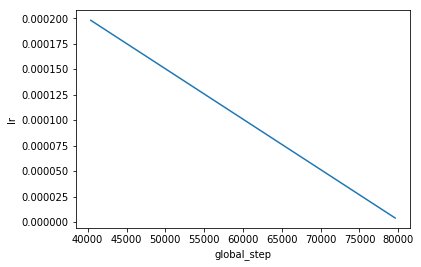

In [70]:
plt.plot(boundaries, values[:-1])
plt.xlabel('global_step')
plt.ylabel('lr');

In [57]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
